# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Notes

1. https://www.youtube.com/watch?v=CG3EV7UBELAnanCount = 0
2. https://www.youtube.com/watch?v=G8Y5PftNnB8
3. https://www.youtube.com/watch?v=99mfBvoYztI
4. Column transformer - https://www.youtube.com/watch?v=5TVj6iEBR4I
5. Groupby - https://www.youtube.com/watch?v=ipoSjrN0oh0&t=12s
   

### Business Ask
We are to look at cars what the dealership can stock up and to see if we can appropriately price them

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
vehicles_df = pd.read_csv('data/vehicles.csv', dtype={'region': str, 'manufacturer' : str})
vehicles_df.head()
vehicles_df.isna().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

we are provided with data of used cars and their suggested prices. The data includes the type of vehicles, the type of fuel it consumes, the number of cylinders in the engine etc. I think information such as type, drive, title_status, conditions definelty play a role in the price of a car. But information such as VIN number, paint, model might not play as big a role in what customers are looking for in a car. 

<Axes: xlabel='condition', ylabel='price'>

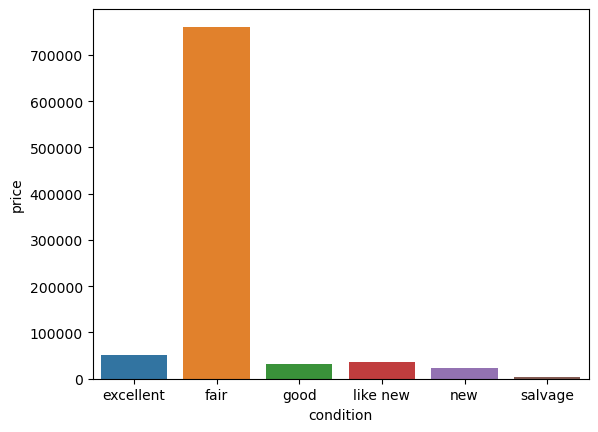

In [11]:
grouped_cond = vehicles_df.groupby(['condition'])['price'].mean()
cond_df = grouped_cond.reset_index()

cond_df['price'] = pd.to_numeric(cond_df['price'], downcast='integer')
sns.barplot(data=cond_df, x='condition',y='price')

In [12]:
vehicles_df.loc[(vehicles_df['price']>100000) & (vehicles_df['condition'] =='fair')]
#There are some outliers in the data for "fair" vehicles that are skewing the price by quite a bit. 

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
134512,7316316781,lewiston / clarkston,123456,2006.0,toyota,tundra limited 4x4,fair,8 cylinders,gas,113350.0,salvage,automatic,NaN,4wd,full-size,truck,grey,id
153082,7305153975,indianapolis,1234567890,2006.0,volvo,vnl,fair,NaN,other,200000.0,clean,manual,NaN,NaN,NaN,NaN,black,in
174085,7302178625,louisville,123456,1997.0,chevrolet,tahoe,fair,8 cylinders,gas,270000.0,clean,automatic,NaN,4wd,full-size,SUV,red,ky
219241,7305419038,southwest MS,1111111,1970.0,dodge,challenger,fair,8 cylinders,gas,42000.0,clean,automatic,NaN,rwd,full-size,coupe,blue,ms
307488,7303218798,stillwater,123456789,1996.0,gmc,sierra 2500,fair,8 cylinders,gas,320000.0,clean,automatic,NaN,4wd,full-size,pickup,black,ok
327938,7314563134,altoona-johnstown,3226714,2002.0,NaN,any and all,fair,8 cylinders,diesel,1234.0,clean,manual,NaN,4wd,mid-size,sedan,blue,pa
328193,7303420900,altoona-johnstown,400123,2003.0,NaN,any and all,fair,5 cylinders,diesel,123321.0,clean,automatic,NaN,4wd,full-size,pickup,blue,pa
356716,7302445002,knoxville,3736928711,1999.0,toyota,4runner,fair,6 cylinders,gas,211000.0,clean,automatic,NaN,4wd,mid-size,NaN,green,tn
379133,7305725228,mcallen / edinburg,25003000,1991.0,chevrolet,camaro,fair,6 cylinders,gas,200000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,tx


<Axes: xlabel='condition', ylabel='price'>

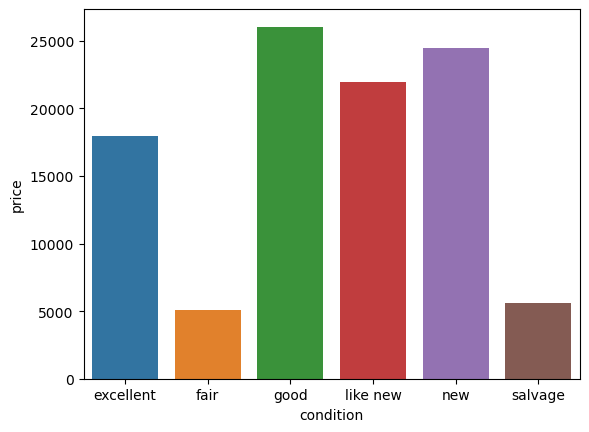

In [13]:
#dropping all rows with price values bigger than 100000
temp_df = vehicles_df.drop(vehicles_df[vehicles_df.price > 100000].index)
temp_df = temp_df.drop(temp_df[temp_df.odometer > 100000].index)
grouped_cond = temp_df.groupby(['condition'])['price'].mean()
cond_df = grouped_cond.reset_index()

cond_df['price'] = pd.to_numeric(cond_df['price'], downcast='integer')
sns.barplot(data=cond_df, x='condition',y='price')

In [14]:
temp_df.dropna()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
126,7305672709,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al
127,7305672266,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al
128,7305672252,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al
268,7315946365,birmingham,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al
338,7315349921,birmingham,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,1.14023E+13,rwd,full-size,coupe,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426780,7303328817,wyoming,34995,2014.0,gmc,sierra,good,8 cylinders,gas,58095.0,clean,automatic,3GTU2VEC1EG297875,4wd,full-size,truck,black,wy
426788,7303227528,wyoming,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,1G1BE5SM0G7266569,fwd,compact,sedan,silver,wy
426793,7303112347,wyoming,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,1G1BE5SM7J7133704,fwd,mid-size,sedan,black,wy
426833,7302338378,wyoming,6800,1997.0,jaguar,xk8 convertible,good,8 cylinders,gas,69550.0,clean,automatic,SAJGX2749VCOO8376,rwd,compact,convertible,white,wy


Text(0.5, 1.0, 'Plot of price and odometer with respect to condition')

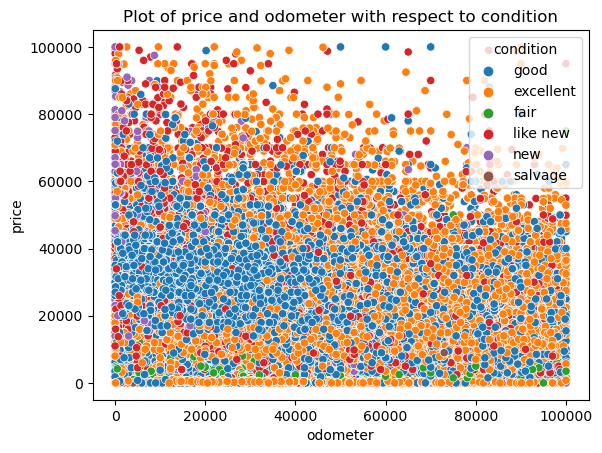

In [15]:
plot = sns.scatterplot(data=temp_df, x='odometer', y='price', hue='condition')
plot.set_title('Plot of price and odometer with respect to condition')

[Text(0, 0, 'acura'),
 Text(1, 0, 'alfa-romeo'),
 Text(2, 0, 'aston-martin'),
 Text(3, 0, 'audi'),
 Text(4, 0, 'bmw'),
 Text(5, 0, 'buick'),
 Text(6, 0, 'cadillac'),
 Text(7, 0, 'chevrolet'),
 Text(8, 0, 'chrysler'),
 Text(9, 0, 'datsun'),
 Text(10, 0, 'dodge'),
 Text(11, 0, 'ferrari'),
 Text(12, 0, 'fiat'),
 Text(13, 0, 'ford'),
 Text(14, 0, 'gmc'),
 Text(15, 0, 'harley-davidson'),
 Text(16, 0, 'honda'),
 Text(17, 0, 'hyundai'),
 Text(18, 0, 'infiniti'),
 Text(19, 0, 'jaguar'),
 Text(20, 0, 'jeep'),
 Text(21, 0, 'kia'),
 Text(22, 0, 'land rover'),
 Text(23, 0, 'lexus'),
 Text(24, 0, 'lincoln'),
 Text(25, 0, 'mazda'),
 Text(26, 0, 'mercedes-benz'),
 Text(27, 0, 'mercury'),
 Text(28, 0, 'mini'),
 Text(29, 0, 'mitsubishi'),
 Text(30, 0, 'morgan'),
 Text(31, 0, 'nissan'),
 Text(32, 0, 'pontiac'),
 Text(33, 0, 'porsche'),
 Text(34, 0, 'ram'),
 Text(35, 0, 'rover'),
 Text(36, 0, 'saturn'),
 Text(37, 0, 'subaru'),
 Text(38, 0, 'tesla'),
 Text(39, 0, 'toyota'),
 Text(40, 0, 'volkswagen'),
 Te

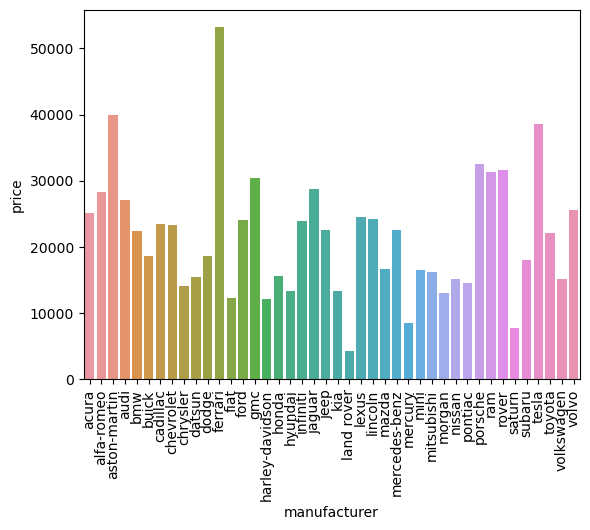

In [16]:
grouped_cond = temp_df.groupby(['manufacturer'])['price'].mean()
cond_df = grouped_cond.reset_index()

cond_df['price'] = pd.to_numeric(cond_df['price'], downcast='integer')
manu_plot = sns.barplot(data=cond_df, x='manufacturer',y='price')
manu_plot.set_xticklabels(manu_plot.get_xticklabels(), rotation=90)

<Axes: xlabel='paint_color', ylabel='price'>

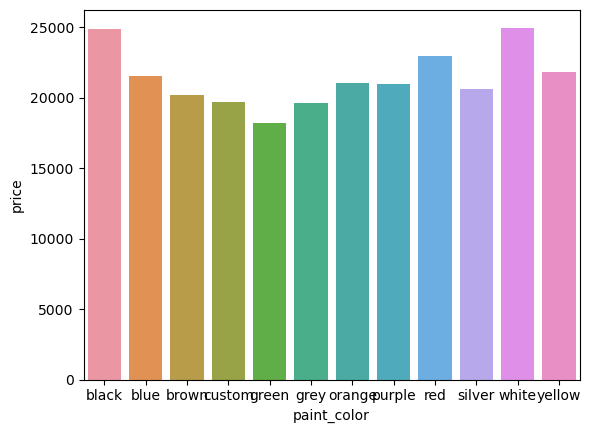

In [17]:
#dropping all rows with price values bigger than 100000
grouped_cond = temp_df.groupby(['paint_color'])['price'].mean()
cond_df = grouped_cond.reset_index()

cond_df['price'] = pd.to_numeric(cond_df['price'], downcast='integer')
sns.barplot(data=cond_df, x='paint_color',y='price')

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [19]:
vehicles_df = vehicles_df.dropna()
vehicles_df = vehicles_df.drop(columns=['VIN','state','model','id','region','manufacturer','paint_color', 'year'])
vehicles_df.head()

,price,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type
126,0,like new,6 cylinders,gas,68472.0,clean,automatic,rwd,full-size,van
127,0,like new,6 cylinders,gas,69125.0,clean,automatic,rwd,full-size,van
128,0,like new,6 cylinders,gas,66555.0,clean,automatic,rwd,full-size,van
215,4000,excellent,4 cylinders,gas,155000.0,clean,automatic,fwd,compact,sedan
219,2500,fair,6 cylinders,gas,110661.0,clean,automatic,rwd,mid-size,sedan


In [20]:
vehicles_df = vehicles_df.drop(vehicles_df[vehicles_df.cylinders == 'other'].index)
vehicles_df = vehicles_df.drop(vehicles_df[vehicles_df.type == 'other'].index)
vehicles_df = vehicles_df.drop(vehicles_df[vehicles_df.fuel == 'other'].index)
vehicles_df = vehicles_df.drop(vehicles_df[vehicles_df.transmission == 'other'].index)

vehicles_df = vehicles_df.drop(vehicles_df[vehicles_df.odometer > 500000].index)
vehicles_df = vehicles_df.drop(vehicles_df[vehicles_df.price < 100].index)

In [21]:
toClean_df = vehicles_df

In [22]:
toEncode = ['condition','title_status','transmission','drive','size','type','fuel']
#obj_cols = newdf.select_dtypes(include='object').columns
encoder = OneHotEncoder(drop='first',sparse_output=False)
one_hot_encoded = encoder.fit_transform(toClean_df[toEncode])
#one_hot_encoded = encoder.fit_transform(newdf[obj_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(toEncode))
one_hot_df.head()

,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,...,type_mini-van,type_offroad,type_pickup,type_sedan,type_truck,type_van,type_wagon,fuel_electric,fuel_gas,fuel_hybrid
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [23]:
toClean_df.reset_index(drop=True, inplace=True)
one_hot_df.reset_index(drop=True, inplace=True)

In [24]:
df_encoded = pd.concat([toClean_df, one_hot_df], axis=1).drop(columns=toEncode)

In [25]:
df_encoded['price'] = df_encoded['price'].replace(0,df_encoded['price'].mean()).apply(lambda x: round(x, 2))

In [26]:
#df_encoded['year'] = pd.to_numeric(df_encoded['year'], downcast='integer')
df_encoded['odometer'] = pd.to_numeric(df_encoded['odometer'], downcast='integer')

#df_encoded['cylinders'] = pd.to_numeric(df_encoded['cylinders'], downcast='integer')

In [27]:
newdf = df_encoded

In [28]:
def convertCylinder(value):
    if '12' in value:
        return '12'
    if '10' in value:
        return '10'
    if '8' in value:
        return '8'
    if '6' in value:
        return '6'
    if '5' in value:
        return '5'
    if '4' in value:
        return '4'
    if '3' in value:
        return '3'


In [29]:
newdf['cylinders'] = newdf['cylinders'].apply(lambda x: convertCylinder(x))

In [30]:
final_df = newdf

In [31]:
# Split the data into training and testing sets
X = final_df.drop(columns=['price'])
y = final_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Identify categorical and numerical columns
categorical_cols = final_df.select_dtypes(include=['object', 'category']).columns
numerical_cols = final_df.select_dtypes(include=['int64', 'float64']).columns.drop('price')

In [33]:
# 2. Create a Column Transformer for preprocessing
preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_cols),
    (StandardScaler(), numerical_cols),
    remainder='passthrough'
)

# 3. Create a Pipeline with Ridge Regression and Polynomial Features
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', TransformedTargetRegressor(regressor=Ridge(), func=np.log, inverse_func=np.exp))
])

In [34]:
# 4. Perform GridSearchCV for Ridge
param_grid = {
    'regressor__regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         Index(['cylinders'], dtype='object')),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         Index(['condition_fair', 'condition_good', 'condition_like new',
       'condition_new', 'condition_salvage', 'title_status_lien',
       'title_statu...
       'type_hatchback', 'type_mini-van', 'type_offroad', 'type_pickup',
       'type_sedan', 'type_truck', 'type_van', 'type_wagon', 'fuel_electric',
       'fuel_gas', 'fuel_hybrid'],
      dtype='object'))])),
                                       ('regressor',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=Ridge()))]),
             param_grid={'regressor__regressor__alpha': [0.01, 0.1, 1.0, 10.0,
                                                         100.0]},
             scoring='neg_mean_squared_error')

In [35]:
# 5. Best Ridge model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 6. Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Best Ridge MSE: {mse}')
# Retrieve the best alpha value found by GridSearchCV
best_alpha = grid_search.best_params_['regressor__regressor__alpha']

# Print the best alpha value
print(f'The best alpha value for the Ridge model is: {best_alpha}')

Best Ridge MSE: 69922294.30165415
The best alpha value for the Ridge model is: 10.0


In [36]:
mse = mean_squared_error(y_test, y_pred)

In [37]:
# 7. Model Interpretation using Permutation Importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

In [38]:
# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': perm_importance.importances_mean
}).sort_values(by='importance', ascending=False)

In [39]:
# Results and Interpretation
importance_df.head(10)

,feature,importance
1,odometer,0.534429
30,fuel_gas,0.142019
13,drive_fwd,0.082399
26,type_truck,0.078827
0,cylinders,0.034467
3,condition_good,0.025714
24,type_pickup,0.025376
25,type_sedan,0.024435
14,drive_rwd,0.024048
2,condition_fair,0.017486


[Text(0, 0, 'odometer'),
 Text(1, 0, 'fuel_gas'),
 Text(2, 0, 'drive_fwd'),
 Text(3, 0, 'type_truck'),
 Text(4, 0, 'cylinders'),
 Text(5, 0, 'condition_good'),
 Text(6, 0, 'type_pickup'),
 Text(7, 0, 'type_sedan'),
 Text(8, 0, 'drive_rwd'),
 Text(9, 0, 'condition_fair'),
 Text(10, 0, 'type_van'),
 Text(11, 0, 'size_full-size'),
 Text(12, 0, 'title_status_rebuilt'),
 Text(13, 0, 'fuel_hybrid'),
 Text(14, 0, 'type_hatchback'),
 Text(15, 0, 'condition_new'),
 Text(16, 0, 'type_wagon'),
 Text(17, 0, 'title_status_salvage'),
 Text(18, 0, 'type_offroad'),
 Text(19, 0, 'size_mid-size'),
 Text(20, 0, 'condition_like new'),
 Text(21, 0, 'type_mini-van'),
 Text(22, 0, 'type_bus'),
 Text(23, 0, 'title_status_missing'),
 Text(24, 0, 'transmission_manual'),
 Text(25, 0, 'type_convertible'),
 Text(26, 0, 'condition_salvage'),
 Text(27, 0, 'fuel_electric'),
 Text(28, 0, 'size_sub-compact'),
 Text(29, 0, 'title_status_lien'),
 Text(30, 0, 'title_status_parts only'),
 Text(31, 0, 'type_coupe')]

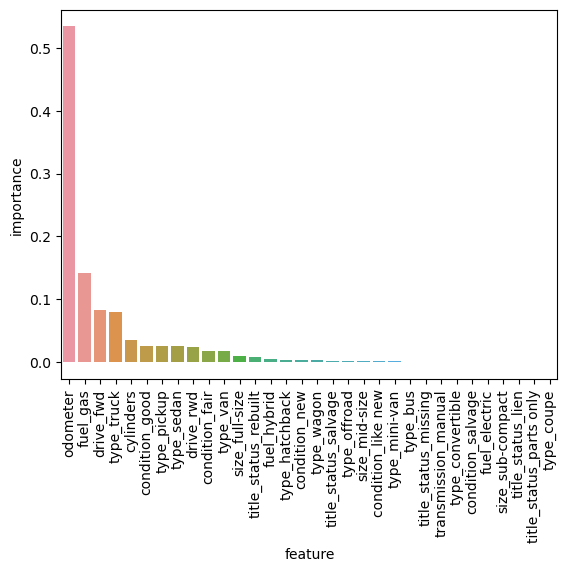

In [40]:
myplot = sns.barplot(data =importance_df, x='feature', y='importance')
myplot.set_xticklabels(myplot.get_xticklabels(), rotation=90)

In [41]:
df_corr = final_df.corr()

<Axes: >

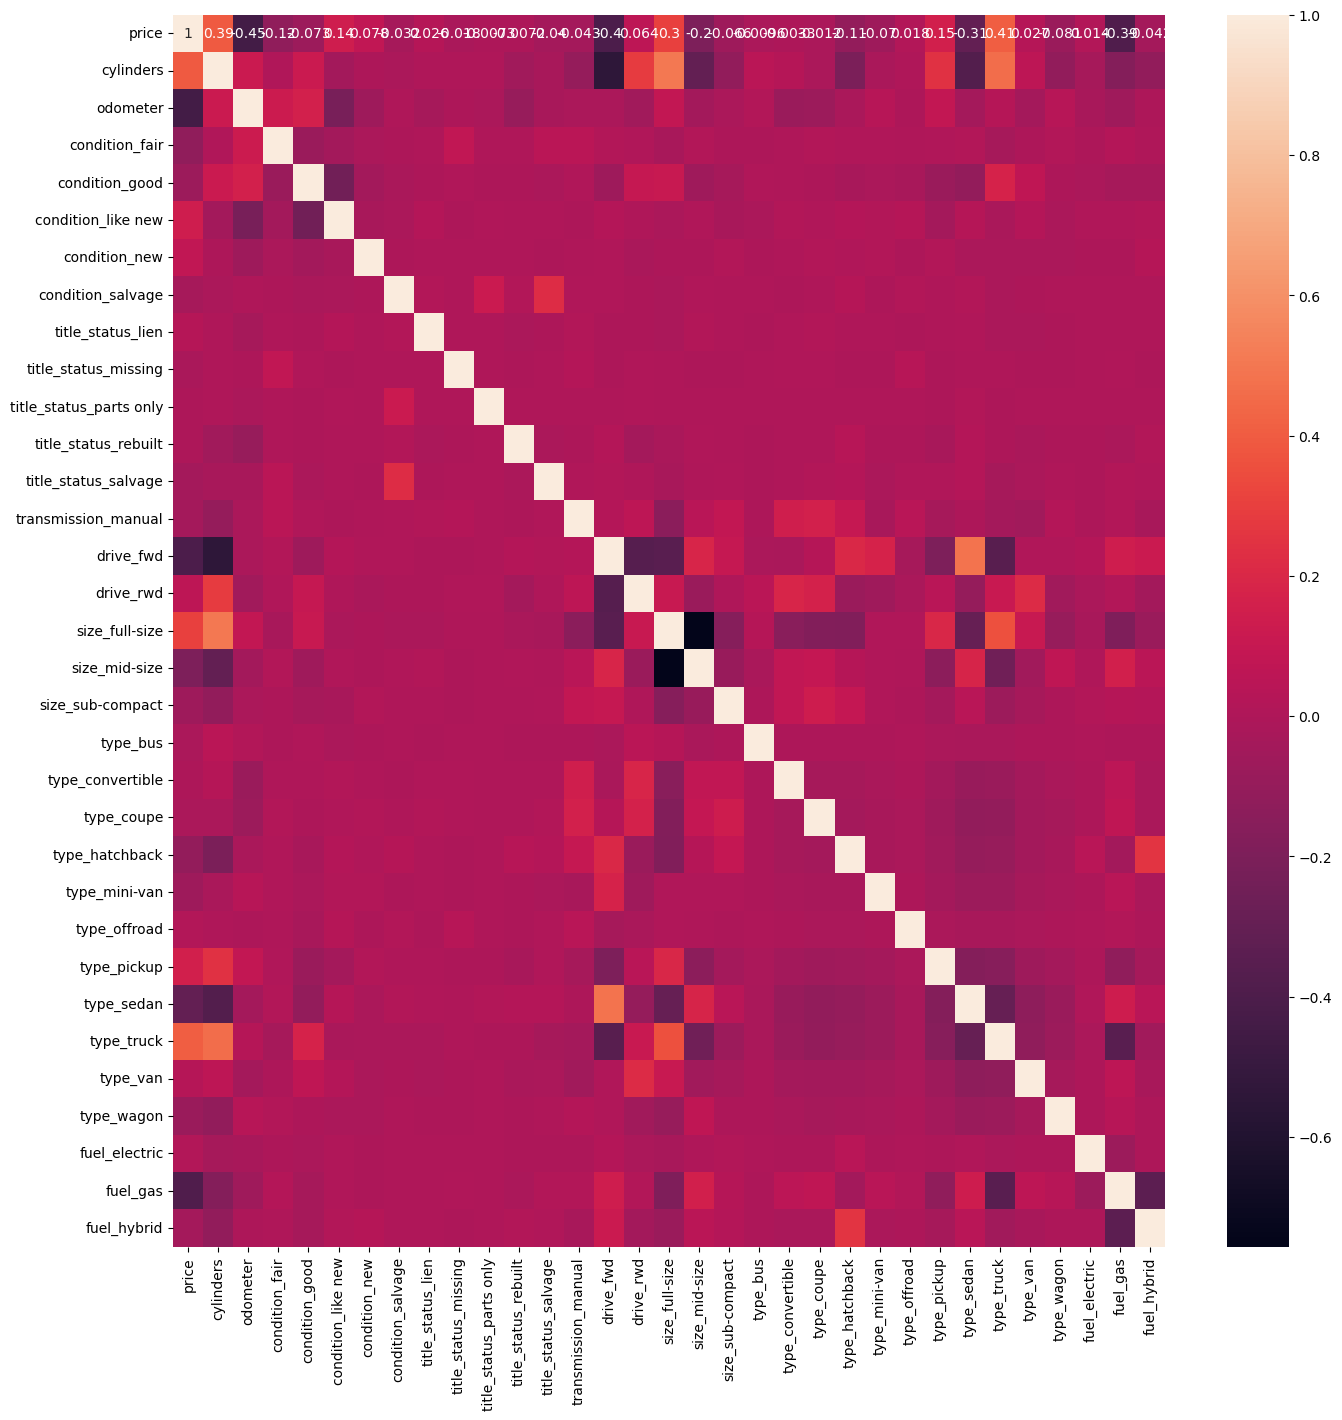

In [42]:
plt.figure(figsize = (16,16))
sns.heatmap(data  = df_corr, annot = True)

In [43]:
df = final_df
df.head()

,price,cylinders,odometer,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,title_status_lien,title_status_missing,...,type_mini-van,type_offroad,type_pickup,type_sedan,type_truck,type_van,type_wagon,fuel_electric,fuel_gas,fuel_hybrid
0,4000,4,155000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2500,6,110661,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,9000,4,56700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,8950,6,164000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,4000,6,88100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [45]:
data = df[['odometer','price']]

<Axes: xlabel='odometer', ylabel='price'>

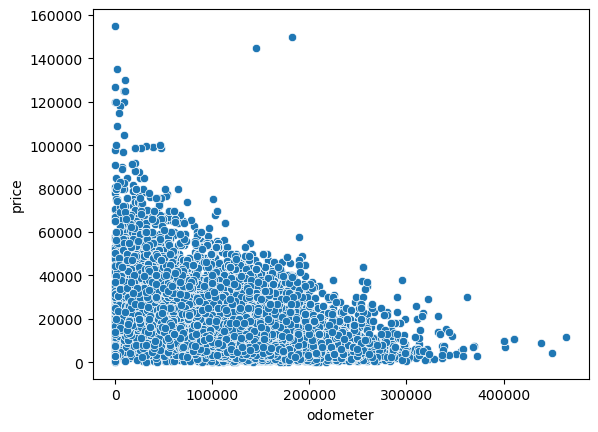

In [46]:
sns.scatterplot(data=df, x="odometer", y="price")

In [47]:
data.describe()

,odometer,price
count,31276.000000,31276.000000
mean,108602.994469,17368.538592
std,56134.112052,13101.557154
min,0.000000,116.000000
25%,69698.000000,7950.000000
50%,107125.000000,13878.500000
75%,143733.250000,23900.000000
max,464213.000000,155000.000000


In [48]:
inputs = data.drop(columns = ['odometer'], axis = 1, inplace=False) # input is hours (X)
targets = data.drop(columns = ['price'], axis = 1, inplace=False) # output is scores (y)

In [49]:
train_inputs,test_inputs, train_targets, test_targets = train_test_split( inputs, targets, test_size=0.2, random_state=42)

In [50]:
model=LinearRegression()

In [51]:
model.fit(train_inputs, train_targets)

LinearRegression()

In [52]:
test_predictions=model.predict(test_inputs)

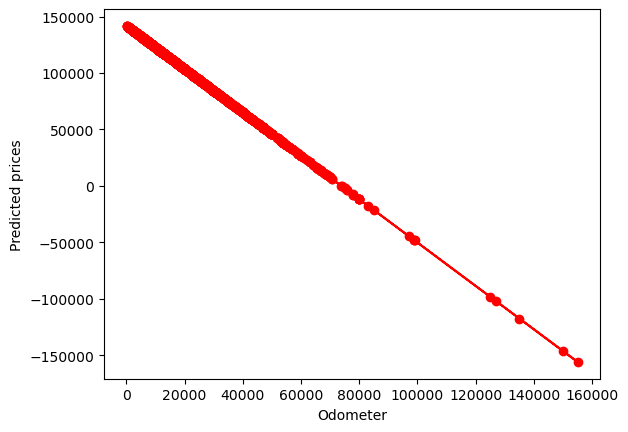

In [53]:
plt.plot(test_inputs,test_predictions, 'r-o');
plt.xlabel('Odometer');
plt.ylabel('Predicted prices');

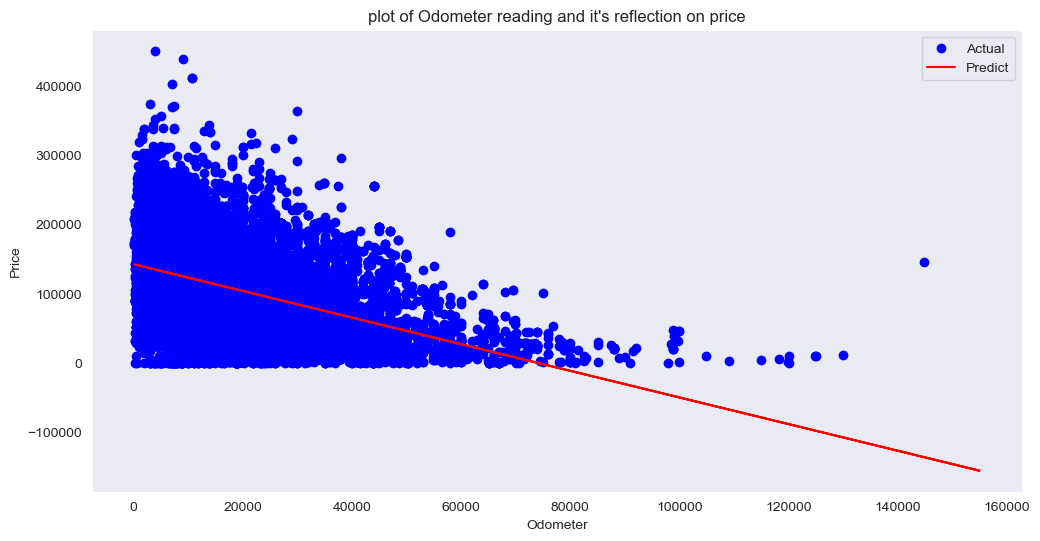

In [54]:
plt.figure(figsize = (12, 6))
sns.set_style("dark")
plt.scatter(train_inputs, train_targets, color='blue')
plt.plot(test_inputs, test_predictions,color='red')
plt.xlabel("Odometer")
plt.ylabel("Price")
plt.title("plot of Odometer reading and it's reflection on price")
plt.legend(['Actual','Predict']);

In [55]:
#not great accuracy!!
score = model.score(test_inputs, test_targets)
print("Accuracy: ", round(score*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(test_targets,test_predictions)), 2))

Accuracy:  19.28
RMSE:      51073.86


### Not good accuracy
When predicting price of a cars, there are multiple factors in play so using just the odometer as a predcitor
is not a good idea.

In [57]:
multi_df = final_df

In [58]:
multi_df.head()

,price,cylinders,odometer,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,title_status_lien,title_status_missing,...,type_mini-van,type_offroad,type_pickup,type_sedan,type_truck,type_van,type_wagon,fuel_electric,fuel_gas,fuel_hybrid
0,4000,4,155000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2500,6,110661,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,9000,4,56700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,8950,6,164000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,4000,6,88100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Using multiple linear regression - 
It seems evident that using multiple features as predictors is better than using just the odometer

In [60]:
lm = LinearRegression()

In [61]:
# let's do the split of the dataset
multi_df.columns
X_multiple = multi_df[['odometer', 'fuel_gas', 'drive_fwd', 'type_truck', 'cylinders', 'condition_good' ]]
y = multi_df['price']

In [62]:
X_train, X_test, y_train, y_test = train_test_split( X_multiple, y, test_size=0.3, random_state=42)

In [63]:
lm.fit(X_train,y_train)

LinearRegression()

In [64]:
coef = pd.DataFrame(lm.coef_, X_train.columns, columns = ['Coefficients'])
coef

,Coefficients
odometer,-0.114435
fuel_gas,-12936.059074
drive_fwd,-5343.777816
type_truck,5083.367657
cylinders,1809.584337
condition_good,-2004.113260


In [65]:
predictions = lm.predict(X_test)

<Axes: xlabel='price'>

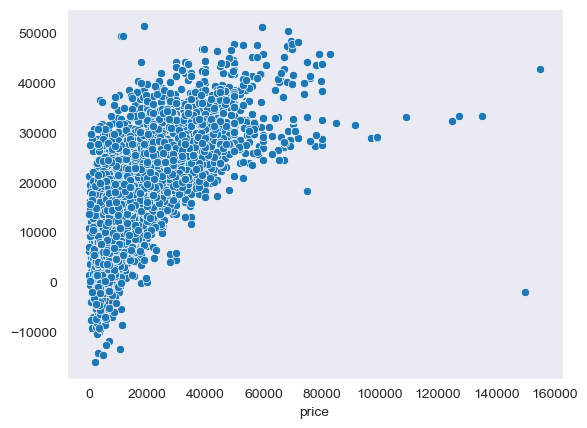

In [66]:
sns.scatterplot(x= y_test, y= predictions)

In [67]:
print('MAE :', metrics.mean_absolute_error(y_test, predictions))
print('MSE :', metrics.mean_squared_error(y_test, predictions))
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE : 6004.935175150455
MSE : 76467263.82740946
RMSE : 8744.556239593263


In [68]:
#accuracy of test data
score = lm.score(X_test, y_test)
print("Accuracy: ", round(score*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y_test,predictions)), 2))

Accuracy:  55.16
RMSE:      8744.56


In [69]:
#accuracy of test data
score = lm.score(X_train, y_train)
print("Accuracy: ", round(score*100, 2))

Accuracy:  57.67


### Ridge

In [71]:
ridge_df = final_df

In [72]:
X = ridge_df.drop('price', axis = 1)
y = ridge_df['price']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [74]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
ridge_coefs = pd.Series(ridge_model.coef_, index=X.columns)
ridge_coefs.sort_values(ascending=False, inplace = True)
ridge_coefs[:6]

condition_new        6842.666333
type_truck           5791.975766
type_pickup          4228.327489
type_van             3751.535120
type_offroad         2732.308531
title_status_lien    2554.873360
dtype: float64

In [75]:
ridge_mse = mean_squared_error(y_test,ridge_model.predict(X_test))
ridge_mse

69522327.68383598

In [76]:
type(ridge_coefs)

pandas.core.series.Series

In [77]:
coef_df = ridge_coefs.to_frame().reset_index()
coef_df = coef_df.rename(columns={'index':'coefs', 0:'value'})

[Text(0, 0, 'condition_new'),
 Text(1, 0, 'type_truck'),
 Text(2, 0, 'type_pickup'),
 Text(3, 0, 'type_van'),
 Text(4, 0, 'type_offroad'),
 Text(5, 0, 'title_status_lien'),
 Text(6, 0, 'condition_like new'),
 Text(7, 0, 'type_coupe'),
 Text(8, 0, 'cylinders'),
 Text(9, 0, 'size_full-size'),
 Text(10, 0, 'type_convertible'),
 Text(11, 0, 'size_mid-size'),
 Text(12, 0, 'size_sub-compact'),
 Text(13, 0, 'transmission_manual'),
 Text(14, 0, 'odometer'),
 Text(15, 0, 'type_mini-van'),
 Text(16, 0, 'condition_good'),
 Text(17, 0, 'type_hatchback'),
 Text(18, 0, 'type_wagon'),
 Text(19, 0, 'type_sedan'),
 Text(20, 0, 'type_bus'),
 Text(21, 0, 'fuel_electric'),
 Text(22, 0, 'title_status_rebuilt'),
 Text(23, 0, 'title_status_salvage'),
 Text(24, 0, 'drive_rwd'),
 Text(25, 0, 'condition_fair'),
 Text(26, 0, 'drive_fwd'),
 Text(27, 0, 'condition_salvage'),
 Text(28, 0, 'title_status_parts only'),
 Text(29, 0, 'fuel_hybrid'),
 Text(30, 0, 'title_status_missing'),
 Text(31, 0, 'fuel_gas')]

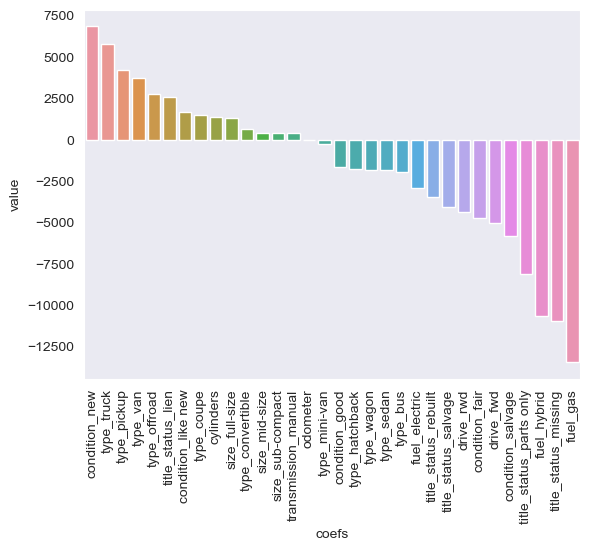

In [78]:
ridgeplot = sns.barplot(data =coef_df, x='coefs', y='value')
ridgeplot.set_xticklabels(ridgeplot.get_xticklabels(), rotation=90)

In [79]:
score = ridge_model.score(X_train, y_train)
print("Accuracy: ", round(score*100, 2))

Accuracy:  62.5


In [80]:
score = ridge_model.score(X_test, y_test)
print("Accuracy: ", round(score*100, 2))

Accuracy:  59.2


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.